In [ ]:
import numpy as np
from math import *
import matplotlib.pylab as plt
import pandas as pd
from pathlib import Path
import matplotlib.colors
import xlsxwriter

#### Для группа Qz(b) использовался λм =6.09Вт/(мК), поскольку при использовании λм =5.02 Вт/(мК), из уравнения регрессии, относительная разница между теорией и экспериментов более 5%

#### Для группа Fsp-Qz(a) использовался λм =4.02Вт/(мК), опредленая по границам ХШ для всех трех групп Fsp-Qz, но для большинства образцов относительная разница между теорией и экспериментов достигала более 5%. Однако!, если использовать λм =3.03 Вт/(мК) из уранения регрессии, то ошибка между теорией и эксперемнто возрастает. Оптимально использовать λм =4.02Вт/(мК), опредленая по границам ХШ, но можно ее еще увеличить, чтобы уменьшить разница межу теорией и экспериментом.

#### Вывод: λ матрицы из уравнение регрессии занижены для групп Qz(b),  Fsp-Qz(a)

### Обратная задача по трем состояниям насыщения. Non-linear algorithm for λм and AR

In [ ]:
"""3 состояние насыщения, 2 комопненты. АО пор - диапазон"""

# Запись в Excel
path1 = Path(r'/Users/maryiakalinina/Desktop/Индия_моделирование/Обратная_три флюида/INDIA_L-115_Fsp-Qz(a)_INV_3.xlsx')
workbook = xlsxwriter.Workbook(path1)
worksheet1 = workbook.add_worksheet('Step 1')

worksheet1.write('A1', 'por%')

worksheet1.write('B1', 'TC_matr_1')
worksheet1.write('C1', 'TC_fluid_1')
worksheet1.write('D1', 'АО пор 1')
worksheet1.write('E1', 'L_eff_1')

worksheet1.write('F1', 'TC_matr_2')
worksheet1.write('G1', 'TC_fluid_2')
worksheet1.write('H1', 'АО пор 2')
worksheet1.write('I1', 'L_eff_2')

worksheet1.write('J1', 'TC_matr_3')
worksheet1.write('K1', 'TC_fluid_3')
worksheet1.write('L1', 'АО пор 3')
worksheet1.write('M1', 'L_eff_3')


N = 3
entered_por = 10.6# ВВОДИТЬ ПОРИСТОСТЬ
lam_matrix_ds=5.05
error_matrix=5
conc = [100 - entered_por, entered_por]
iprs = 2 #  1 - Границы ХШ (т.е. не работает итерация); 2 - м-д самосогласования (работает на итерациях)
error = 10

#  -------------------------------------------------------------
"""Состояние насыщение 1"""
experiment_data_1 = 2.61
min_error_1 = experiment_data_1 - (experiment_data_1*error/100)
max_error_1 = experiment_data_1 + (experiment_data_1*error/100)
# print(min_error_1, max_error_1)
#  -------------------------------------------------------------
"""Состояние насыщения 2"""
experiment_data_2 = 3.95
min_error_2 = experiment_data_2 - (experiment_data_2*error/100)
max_error_2 = experiment_data_2 + (experiment_data_2*error/100)

#  -------------------------------------------------------------
"""Состояние насыщения 3"""
experiment_data_3 = 3.28
min_error_3 = experiment_data_3 - (experiment_data_3*error/100)
max_error_3 = experiment_data_3 + (experiment_data_3*error/100)

# conc_node = 0  # кол-во точек (узлов) на трещинную пористость
# conc_cracks = list(np.linspace(0, 0, conc_node))
# total_porosity = np.full(conc_node, conc[1])
# print(total_porosity)
# conc_pore = np.full(conc_node, conc[1])

# n1, n2, n3 = 10, 0, 201 # кол-во узлов матрицы, АО трещин, АО пор
n1, n2= 5, 501 # кол-во узлов матрицы, АО пор

m_list_1 = list(np.linspace(lam_matrix_ds-lam_matrix_ds*error_matrix/100, lam_matrix_ds+lam_matrix_ds*error_matrix/100, n1))   #  ДИАПАЗОН ИЗМЕНЕНИЯ МАТРИЦЫ ДЛЯ СОСТОЯНИЯ 1 (метан)
m_list_2 = list(np.linspace(lam_matrix_ds-lam_matrix_ds*error_matrix/100, lam_matrix_ds+lam_matrix_ds*error_matrix/100, n1))  #  ДИАПАЗОН ИЗМЕНЕНИЯ МАТРИЦЫ ДЛЯ СОСТОЯНИЯ 3 (воздух)
m_list_3 = list(np.linspace(lam_matrix_ds-lam_matrix_ds*error_matrix/100, lam_matrix_ds+lam_matrix_ds*error_matrix/100, n1))  #  ДИАПАЗОН ИЗМЕНЕНИЯ МАТРИЦЫ ДЛЯ СОСТОЯНИЯ 2 (керосин)

# print('Емкость трещин', conc_cracks)
print(m_list_1)
print(m_list_2)
print(m_list_3)
# print('Пористость, ', conc_pore)

pore_alp_fl = np.logspace(-4, 0, num=n2, base=10) #  ДИАПАЗОН ИЗМЕНЕНИЯ АО ПОР
# pore_alp_fl = np.linspace(0.05, 0.3, n3)
# und_alp_fl = np.round(np.logspace(-2, 0, num=n2, base=10), 5) #  ДИАПАЗОН ИЗМЕНЕНИЯ АО ТРЕЩИН

# print(pore_alp_fl)
# print(und_alp_fl)

#--------------Пересчет пористости в доли единиц-----
def effective(alpha_shape, lam, conc):

    phi = [] # пересчет пористости в доли единиц
    for i in conc:
        i = i/100
        phi.append(i)

    #------------------depolarization factor calculation-----
    def depolarizaton(alpha):

        if alpha < 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2-1)
            t5 = np.arctan(t4)
            t8 = t4 ** 2
            form = t2 * (t4-t5) / t8 / t4
            return form
        elif alpha > 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1-t2)
            t6 = np.log(1+t4)
            t9 = np.log(1-t4)
            t13 = t4 ** 2
            form = t2 * (t6 / 2-t9 / 2-t4) / t13 / t4
            return form
        elif alpha == 1:
            form = 1 / 3
            return form


    depolar_F = []
    for i in alpha_shape:
        depolar_F.append(depolarizaton(i))
    # print('коэфф. деполяризации',depolar_F) #  Коэффциент деполяризации для компонент как они были введены

    # #!-----------Расчет эффективной ТС-------------------------------------------------------------------------------
    # L0 - тело сравнения!!!!!!!!
    if iprs == 1 and all(i == 1 for i in alpha_shape): #  Верхняя граница ХШ ТОЛЬКО ДЛЯ СФЕРИЧЕСКИХ ВКЛЮЧЕНИЙ. АО =1
        L0 = lam[0]

        def raschet(L0):

            parall_comp, perpen_comp = [], []

            # print('Тело сравнения', L0)
            for i, j, f in zip(phi, lam, depolar_F):

                termc_3 = i * j / (L0 * (1-f)+j * f)
                termz_3 = i / (L0 * (1-f)+j * f)

                termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
                termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

                termc_all = (termc_3+2 * termc_12) / 3
                termz_all = (termz_3+2 * termz_12) / 3

                t16 = termc_all
                t15 = termz_all

                parall_comp.append(t16)
                perpen_comp.append(t15)
            #
            # print('Параллельный компоненты ТС', parall_comp)
            # print('Перпендикулярные компоненты ТС', perpen_comp)

            L_eff = sum(parall_comp) / sum(perpen_comp)
            # print('TC eff: ', L_eff, end='\n\n')
            return L_eff

        # print('Эффективное значение TC_eff (совпадает с верхней границей ХШ):', raschet(L0))
        # print('1')

    elif iprs == 2 or (iprs == 1 and any(i != 1 for i in alpha_shape)):  #  метод самосогласования ОСП

        L0 = lam[0]

        def raschet(L0):

            parall_comp, perpen_comp = [], []
            # print('Тело сравнения', L0)

            for i, j, f in zip(phi, lam, depolar_F):
                termc_3 = i * j / (L0 * (1-f)+j * f)
                termz_3 = i / (L0 * (1-f)+j * f)

                termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
                termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

                termc_all = (termc_3+2 * termc_12) / 3
                termz_all = (termz_3+2 * termz_12) / 3

                t16 = termc_all
                t15 = termz_all

                parall_comp.append(t16)  # параллельная компонента ТС
                perpen_comp.append(t15)  # перпендикулярная компонента ТС

            # print('Параллельный компоненты ТС', parall_comp)
            # print('Перпендикулярные компоненты ТС', perpen_comp)

            L_eff = round(sum(parall_comp) / sum(perpen_comp), 6)
            # print('TC eff: ', L_eff, end='\n\n')
            return L_eff

        x0 = L0
        L0 = raschet(x0)
        it_f = 1

        while abs(x0-L0) >= 10 ** -3:
            x0 = L0
            L0 = raschet(x0)
            it_f += 1
        else:
            # print('ФИНАЛЬНЫЙ РЕЗУЛЬТАТ')
            # print('Количество итераций: ', it_f)
            return raschet(x0)


all_result_eff_av1, all_result_eff_av2, all_result_eff_av3 = [], [], []

draft_matrix_list1,  draft_fluid_list1, draft_ar_pore1, draft_conc_pore1, draft_ar_cracks1, draft_cocnc_cracks1 = [], [], [], [], [], []
draft_matrix_list2,  draft_fluid_list2, draft_ar_pore2, draft_conc_pore2, draft_ar_cracks2, draft_cocnc_cracks2 = [], [], [], [], [], []
draft_matrix_list3,  draft_fluid_list3, draft_ar_pore3, draft_conc_pore3, draft_ar_cracks3, draft_cocnc_cracks3 = [], [], [], [], [], []
#  ---------------------------------------------------------------------------------------------------------------------
row = 0
col = 0

"""Состояние насыщения 1"""

for i in m_list_1:

    # lam1 = [i, 0.128, 0.128]
    lam1 = [i, 0.025]
#     print('\n\n')
    # print('Значение матрицы: ', i, '----------------------------------------------------------------------------')

    for asp_ratio_pore in pore_alp_fl:

        alpha_shape = [1, asp_ratio_pore]
            # print('Аспектное отношение ', alpha_shape)

        new_conc = conc
        # print('Объёмные концентрации ', new_conc)

        worksheet1.write(row+1, col, conc[1]/100)
        worksheet1.write(row+1, col+1, i)
        worksheet1.write(row+1, col+2, lam1[1])
        worksheet1.write(row+1, col+3, alpha_shape[1])
        worksheet1.write(row+1, col+4, effective(alpha_shape, lam1, new_conc))

        row += 1
        #------------------------------
        draft_matrix_list1.append(i)
        draft_fluid_list1.append(lam1[1])
        draft_conc_pore1.append(conc[1]/100)
        draft_ar_pore1.append(alpha_shape[1])
        all_result_eff_av1.append(effective(alpha_shape, lam1, new_conc))
        #------------------------------

        # print('\n\n')

print('Значение в списке для каждого АО. Состояние 1')
# print(all_result_eff_av1)

#  ---------------------------------------------------------------------------------------------------------------------
"""Состояние насыщения 2"""

row = 0
col = 0

for i in m_list_2:

    lam2 = [i, 0.60]
#     print('\n\n')
    # print('Значение матрицы: ', i, '----------------------------------------------------------------------------')

    for asp_ratio_pore in pore_alp_fl:

        alpha_shape = [1.0, asp_ratio_pore]
        # print('Аспектное отношение ', alpha_shape)

        new_conc = conc
        # print('Объёмные концентрации ', new_conc)

        worksheet1.write(row+1, col+5, i)
        worksheet1.write(row+1, col+6, lam2[1])
        worksheet1.write(row+1, col+7, alpha_shape[1])
        worksheet1.write(row+1, col+8, effective(alpha_shape, lam2, new_conc))
        row += 1

        #------------------------------
        draft_matrix_list2.append(i)
        draft_fluid_list2.append(lam2[1])
        draft_conc_pore2.append(conc[1]/100)
        draft_ar_pore2.append(alpha_shape[1])
        all_result_eff_av2.append(effective(alpha_shape, lam2, new_conc))
        #------------------------------

        # print('\n\n')

print('Значение в списке для каждого АО. Состояние 2')
# print(all_result_eff_av2)

#  ---------------------------------------------------------------------------------------------------------------------
"""Состояние насыщения 3"""

row = 0
col = 0

for i in m_list_3:

    lam3 = [i, 0.13]
#     print('\n\n')
    # print('Значение матрицы: ', i, '----------------------------------------------------------------------------')

    for asp_ratio_pore in pore_alp_fl:

        alpha_shape = [1.0, asp_ratio_pore]
        # print('Аспектное отношение ', alpha_shape)

        new_conc = conc
        # print('Объёмные концентрации ', new_conc)

        worksheet1.write(row+1, col+9, i)
        worksheet1.write(row+1, col+10, lam3[1])
        worksheet1.write(row+1, col+11, alpha_shape[1])
        worksheet1.write(row+1, col+12, effective(alpha_shape, lam3, new_conc))
        row += 1

        #------------------------------
        draft_matrix_list3.append(i)
        draft_fluid_list3.append(lam3[1])
        draft_conc_pore3.append(conc[1]/100)
        draft_ar_pore3.append(alpha_shape[1])
        all_result_eff_av3.append(effective(alpha_shape, lam3, new_conc))
        #------------------------------

        # print('\n\n')

print('Значение в списке для каждого АО. Состояние 2')
# print(all_result_eff_av2)


''''Step 2 - Отбор решений эффективной величины, которые входят в пошрешность %'''
print('Step 2 - Отбор решений эффективной величины, которые входят в пошрешность %')

worksheet2 = workbook.add_worksheet('Step 2')

worksheet2.write('A1', 'por%')

worksheet2.write('B1', 'TC_matr_1')
worksheet2.write('C1', 'TC_fluid_1')
worksheet2.write('D1', 'АО пор 1')
worksheet2.write('E1', 'L_eff_1')
worksheet2.write('F1', 'Diff_1')

worksheet2.write('G1', 'conc_pore_2')
worksheet2.write('H1', 'TC_matr_2')
worksheet2.write('I1', 'TC_fluid_2')
worksheet2.write('J1', 'АО пор 2')
worksheet2.write('K1', 'L_eff_2')
worksheet2.write('L1', 'Diff_2')

worksheet2.write('M1', 'conc_pore_2')
worksheet2.write('N1', 'TC_matr_3')
worksheet2.write('O1', 'TC_fluid_3')
worksheet2.write('P1', 'АО пор 3')
worksheet2.write('Q1', 'L_eff_3')
worksheet2.write('R1', 'Diff_3')

matrix1, fluid1, ar_pore1, eff_l1, conc_pore1 = [], [], [], [], []
matrix2, fluid2, ar_pore2, eff_l2, conc_pore2 = [], [], [], [], []
matrix3, fluid3, ar_pore3, eff_l3, conc_pore3 = [], [], [], [], []


row = 0
col = 0

"""Состояние  1"""

for i in range(n1*n2 - 1):

    if min_error_1 <= all_result_eff_av1[i] <= max_error_1:

        matrix1.append(draft_matrix_list1[i])
        fluid1.append(draft_fluid_list1[i])
        conc_pore1.append(draft_conc_pore1[i])
        ar_pore1.append(draft_ar_pore1[i])
        eff_l1.append(all_result_eff_av1[i])
        #------------------------------
        worksheet2.write(row+1, col, conc[1]/100)
        worksheet2.write(row+1, col+1, draft_matrix_list1[i])
        worksheet2.write(row+1, col+2, draft_fluid_list1[i])
        worksheet2.write(row+1, col+3, draft_ar_pore1[i])
        worksheet2.write(row+1, col+4, all_result_eff_av1[i])
        #------------------------------
        row += 1

diff_1 = [] # относительное расхождение между теорией и экспирементов в процентах

row = 0
col = 0

for theory in eff_l1:

    # diff_1.append((experiment_data_1 - theory)/theory * 100)
    # worksheet2.write(row+1, col+8, ((experiment_data_1 - theory)/theory * 100))

    diff_1.append((theory - experiment_data_1)/experiment_data_1 * 100)
    worksheet2.write(row+1, col+5, (theory - experiment_data_1)/experiment_data_1 * 100)
    row += 1
# print(diff_1)

del draft_matrix_list1
del draft_fluid_list1
del draft_ar_pore1
del draft_conc_pore1

#---------------------------------------------------------------------------------------------
row = 0
col = 0

"""Состояние  2"""

for i in range(n1*n2 - 1):

    if min_error_2 <= all_result_eff_av2[i] <= max_error_2:

        matrix2.append(draft_matrix_list2[i])
        fluid2.append(draft_fluid_list2[i])
        conc_pore2.append(draft_conc_pore2[i])
        ar_pore2.append(draft_ar_pore2[i])
        eff_l2.append(all_result_eff_av2[i])

        #------------------------------
        worksheet2.write(row+1, col+6, draft_conc_pore2[i])
        worksheet2.write(row+1, col+7,  draft_matrix_list2[i])
        worksheet2.write(row+1, col+8, draft_fluid_list2[i])
        worksheet2.write(row+1, col+9, draft_ar_pore2[i])
        worksheet2.write(row+1, col+10, all_result_eff_av2[i])
        #------------------------------
        row += 1

diff_2 = [] # относительное расхождение между теорией и экспирементов в процентах

row = 0
col = 0

for theory in eff_l2:

    # diff_2.append((experiment_data_2 - theory)/theory * 100)
    # worksheet2.write(row+1, col+16, ((experiment_data_2 - theory)/theory * 100))

    diff_2.append((theory - experiment_data_2)/experiment_data_2 * 100)
    worksheet2.write(row+1, col+11, (theory - experiment_data_2)/experiment_data_2 * 100)
    row += 1


del draft_matrix_list2
del draft_fluid_list2
del draft_ar_pore2
del draft_conc_pore2

#---------------------------------------------------------------------------------------------
row = 0
col = 0

"""Состояние  3"""

for i in range(n1*n2 - 1):

    if min_error_3 <= all_result_eff_av3[i] <= max_error_3:

        matrix3.append(draft_matrix_list3[i])
        fluid3.append(draft_fluid_list3[i])
        conc_pore3.append(draft_conc_pore3[i])
        ar_pore3.append(draft_ar_pore3[i])
        eff_l3.append(all_result_eff_av3[i])

        #------------------------------
        worksheet2.write(row+1, col+12, draft_conc_pore3[i])
        worksheet2.write(row+1, col+13,  draft_matrix_list3[i])
        worksheet2.write(row+1, col+14, draft_fluid_list3[i])
        worksheet2.write(row+1, col+15, draft_ar_pore3[i])
        worksheet2.write(row+1, col+16, all_result_eff_av3[i])
        #------------------------------
        row += 1

diff_3 = [] # относительное расхождение между теорией и экспирементов в процентах

row = 0
col = 0

for theory in eff_l3:

    # diff_2.append((experiment_data_2 - theory)/theory * 100)
    # worksheet2.write(row+1, col+16, ((experiment_data_2 - theory)/theory * 100))

    diff_3.append((theory - experiment_data_3)/experiment_data_3 * 100)
    worksheet2.write(row+1, col+17, (theory - experiment_data_3)/experiment_data_3 * 100)
    row += 1


del draft_matrix_list3
del draft_fluid_list3
del draft_ar_pore3
del draft_conc_pore3

# draft_matrix_list1.clear(), draft_fluid_list1.clear(), draft_ar_pore1.clear(), draft_conc_pore1.clear(), draft_ar_cracks1.clear(), draft_cocnc_cracks1.clear()
# draft_matrix_list2.clear(), draft_fluid_list2.clear(), draft_ar_pore2.clear(), draft_conc_pore2.clear(), draft_ar_cracks2.clear(), draft_cocnc_cracks2.clear()

""""Остановка программы, если на Step 2 (отбор эфф.значений в пределах погрешности) хотя бы у одного из состояний
насыщения нет отобранных эфф. значений"""
if len(eff_l1) == 0 or len(eff_l2) == 0 or len(eff_l3) == 0:
    print('НЕОБХОДИМО ИЗМЕНЕНИТЬ ВХОДНЫЕ ДАННЫЕ - НЕТ РЕШЕНИЙ')
    sys.exit()

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
''''Step 3 - Наложение решений, которые удовлятворяют заданной пошрешности, друг на друга'''
print('Step 3 - Наложение решений, которые удовлятворяют заданной пошрешности, друг на друга')
print('Step 3* - Из наложенного множества отбираются те значения, которые имеет одинакувую пористость и '
      'AMIN (расхождение между АО трещин) равной 0')

matrix1_3, fluid1_3, ar_pore1_3, eff_l1_3, conc_pore1_3, diff1_3 = [], [], [], [], [], []
matrix2_3, fluid2_3, ar_pore2_3, eff_l2_3, conc_pore2_3, diff2_3 = [], [], [], [], [], []
matrix3_3, fluid3_3, ar_pore3_3, eff_l3_3, conc_pore3_3, diff3_3 = [], [], [], [], [], []
amin_pore = []
ε_list = []

# for i in range(len(conc_cracks1_3)):

#     if conc_pore1_3[i] == conc_pore2_3[i] and amin_pore[i] == 0 and conc_cracks1_3[i] == conc_cracks2_3[i] \
#             and amin[i] == 0:

worksheet3 = workbook.add_worksheet('Step 3')

worksheet3.write('A1', 'por%')

worksheet3.write('B1', 'TC_matr_1')
worksheet3.write('C1', 'TC_fluid_1')
worksheet3.write('D1', 'АО пор 1')
worksheet3.write('E1', 'L_eff_1')
worksheet3.write('F1', 'Diff_1')

worksheet3.write('G1', 'TC_matr_2')
worksheet3.write('H1', 'TC_fluid_2')
worksheet3.write('I1', 'АО пор 2')
worksheet3.write('J1', 'L_eff_2')
worksheet3.write('K1', 'Diff_2')

worksheet3.write('L1', 'TC_matr_3')
worksheet3.write('M1', 'TC_fluid_3')
worksheet3.write('N1', 'АО пор 3')
worksheet3.write('O1', 'L_eff_3')
worksheet3.write('P1', 'Diff_3')

worksheet3.write('Q1', 'AMIN PORE')
worksheet3.write('R1', 'ε')

row = 0
col = 0


"""Наложение сеток для двух состояний"""

for i in range(len(matrix1)):

    for j in range(len(matrix2)):

        for k in range(len(matrix3)):

            if conc_pore1[i] == conc_pore2[j] and ar_pore1[i] == ar_pore2[j] == ar_pore3[k]:

                matrix1_3.append(matrix1[i])
                matrix2_3.append(matrix2[j])
                matrix3_3.append(matrix3[k])

                fluid1_3.append(fluid1[i])
                fluid2_3.append(fluid2[j])
                fluid3_3.append(fluid3[k])

                conc_pore1_3.append(conc_pore1[i])
                conc_pore2_3.append(conc_pore2[j])
                conc_pore3_3.append(conc_pore3[k])

                ar_pore1_3.append(ar_pore1[i])
                ar_pore2_3.append(ar_pore2[j])
                ar_pore3_3.append(ar_pore3[k])

                diff1_3.append(diff_1[i])
                diff2_3.append(diff_2[j])
                diff3_3.append(diff_3[k])

                amin_pore.append((ar_pore1[i] + ar_pore2[j] + ar_pore3[k])/3)

                eff_l1_3.append(eff_l1[i])
                eff_l2_3.append(eff_l2[j])
                eff_l3_3.append(eff_l3[k])

                ε_list.append((3*conc[1]/100)/(4*pi*ar_pore1[i]))

                worksheet3.write(row+1, col, conc[1]/100)

                worksheet3.write(row+1, col+1,  matrix1[i])
                worksheet3.write(row+1, col+2, fluid1[i])
                worksheet3.write(row+1, col+3, ar_pore1[i])
                worksheet3.write(row+1, col+4, eff_l1[i])
                worksheet3.write(row+1, col+5, diff_1[i])

                worksheet3.write(row+1, col+6, matrix2[j])
                worksheet3.write(row+1, col+7, fluid2[j])
                worksheet3.write(row+1, col+8, ar_pore2[j])
                worksheet3.write(row+1, col+9, eff_l2[j])
                worksheet3.write(row+1, col+10, diff_2[j])

                worksheet3.write(row+1, col+11, matrix3[k])
                worksheet3.write(row+1, col+12, fluid3[k])
                worksheet3.write(row+1, col+13, ar_pore3[k])
                worksheet3.write(row+1, col+14, eff_l3[k])
                worksheet3.write(row+1, col+15, diff_3[k])

                worksheet3.write(row+1, col+16, (ar_pore1[i] + ar_pore2[j] + ar_pore3[k])/3)
                worksheet3.write(row+1, col+17, (3*conc[1]/100)/(4*pi*ar_pore1[i]))

                #------------------------------
                row += 1

del matrix1
del fluid1
del conc_pore1
del ar_pore1
del diff_1
del eff_l1

del matrix2
del fluid2
del conc_pore2
del ar_pore2
del diff_2
del eff_l2

del matrix3
del fluid3
del conc_pore3
del ar_pore3
del diff_3
del eff_l3

#----------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------
''''Step 5 - Нахождение лучшего решения по дополнительному шагу Step 3,4,5 (additional)'''
"""Выбор одного лучшего решения из Step 5 (если на Step 4 их было больше чем одно) """

print('Step 5 - Нахождение лучшего решения по дополнительному шагу Step 3,4,5 (additional)')

# matrix1_3, fluid1_3, ar_pore1_3, ar_cracks1_3, eff_l1_3, conc_pore1_3, conc_cracks1_3, diff1_3 = [], [], [], [], [], [], [], []
# matrix2_3, fluid2_3, ar_pore2_3, ar_cracks2_3, eff_l2_3, conc_pore2_3, conc_cracks2_3, diff2_3 = [], [], [], [], [], [], [], []
# amin, amin_pore = [], []

amin_zero = []
best_amin = []
diff_last = []

if len(amin_pore) > 1:

    print('Есть одно общее решение')

    for fluid1, fluid2, fluid3 in zip(diff1_3, diff2_3, diff3_3):

        diff_last.append(np.sqrt(fluid1**2 + fluid2**2 + fluid3**2))

    min_diff = diff_last.index(min(diff_last)) #  index

    worksheet4 = workbook.add_worksheet('Step 6 (BEST)')

    worksheet4.write('A1', 'por%')

    worksheet4.write('B1', 'TC_matr_1')
    worksheet4.write('C1', 'TC_fluid_1')
    worksheet4.write('D1', 'АО пор 1')
    worksheet4.write('E1', 'L_eff_1')
    worksheet4.write('F1', 'Exp1')
    worksheet4.write('G1', 'Diff_1')

    worksheet4.write('H1', 'TC_matr_2')
    worksheet4.write('I1', 'TC_fluid_2')
    worksheet4.write('J1', 'АО пор 2')
    worksheet4.write('K1', 'L_eff_2')
    worksheet4.write('L1', 'Exp2')
    worksheet4.write('M1', 'Diff_2')

    worksheet4.write('N1', 'TC_matr_3')
    worksheet4.write('O1', 'TC_fluid_3')
    worksheet4.write('P1', 'АО пор 3')
    worksheet4.write('Q1', 'L_eff_3')
    worksheet4.write('R1', 'Exp3')
    worksheet4.write('S1', 'Diff_3')


    worksheet4.write('T1', 'AMINI 1, 2, 3, 4') # расхождение между АО ТРЕЩИН!!!!!!!!!!!!!!
    worksheet4.write('U1', '√Diff')

    row = 0
    col = 0

    worksheet4.write(row+1, col, conc[1]/100)

    worksheet4.write(row+1, col+1, matrix1_3[min_diff])
    worksheet4.write(row+1, col+2, fluid1_3[min_diff])
    worksheet4.write(row+1, col+3, ar_pore1_3[min_diff])
    worksheet4.write(row+1, col+4, eff_l1_3[min_diff])
    worksheet4.write(row+1, col+5, experiment_data_1)
    worksheet4.write(row+1, col+6,  diff1_3[min_diff])

    worksheet4.write(row+1, col+7, matrix2_3[min_diff])
    worksheet4.write(row+1, col+8, fluid2_3[min_diff])
    worksheet4.write(row+1, col+9, ar_pore2_3[min_diff])
    worksheet4.write(row+1, col+10, eff_l2_3[min_diff])
    worksheet4.write(row+1, col+11, experiment_data_2)
    worksheet4.write(row+1, col+12,  diff2_3[min_diff])

    worksheet4.write(row+1, col+13, matrix3_3[min_diff])
    worksheet4.write(row+1, col+14, fluid3_3[min_diff])
    worksheet4.write(row+1, col+15, ar_pore3_3[min_diff])
    worksheet4.write(row+1, col+16, eff_l3_3[min_diff])
    worksheet4.write(row+1, col+17, experiment_data_3)
    worksheet4.write(row+1, col+18,  diff3_3[min_diff])

    worksheet4.write(row+1, col+19, amin_pore[min_diff])
    worksheet4.write(row+1, col+20, min(diff_last))

    row += 1

elif all(value != 0 for value in amin_pore) and len(amin_pore) != 0:

    print('Нет единого решения АО')

elif len(amin_pore) == 0:

    print('НЕОБХОДИМО ИЗМЕНЕНИТЬ ВХОДНЫЕ ДАННЫЕ - ПОГРЕШНОСТЬ МОДЕЛИРОВАНИЯ (ERROR)')

workbook.close()

print('End')

[4.797499999999999, 4.92375, 5.05, 5.17625, 5.3025]
[4.797499999999999, 4.92375, 5.05, 5.17625, 5.3025]
[4.797499999999999, 4.92375, 5.05, 5.17625, 5.3025]
Значение в списке для каждого АО. Состояние 1
Значение в списке для каждого АО. Состояние 2
Значение в списке для каждого АО. Состояние 2
Step 2 - Отбор решений эффективной величины, которые входят в пошрешность %
Step 3 - Наложение решений, которые удовлятворяют заданной пошрешности, друг на друга
Step 3* - Из наложенного множества отбираются те значения, которые имеет одинакувую пористость и AMIN (расхождение между АО трещин) равной 0
Step 5 - Нахождение лучшего решения по дополнительному шагу Step 3,4,5 (additional)
Есть одно общее решение
End


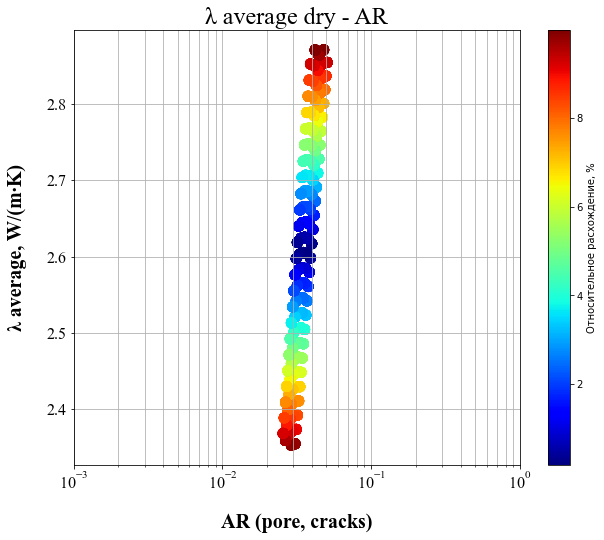

In [ ]:
path_to_ser1 = path1
df_ues1 = pd.read_excel(path_to_ser1, sheet_name='Step 3')
df_ues1.head()

# Delte duplicate values in rows
# drop2= df_ues2.drop_duplicates(subset=["АО пор 1"])
# x2_values, y2_values = drop2["АО пор 1"], drop2["L_eff_1"]


# Without delte duplicate values in rows
x_values, y_values = df_ues1["АО пор 1"], df_ues1["L_eff_1"]

csfont = {'fontname':'Times New Roman'}
fig,ax = plt.subplots(figsize=(10, 8))
plt.grid(True)


plt.scatter(x=x_values,
            y=y_values,
            c = abs(df_ues1["Diff_1"]),
            vmin=abs(df_ues1["Diff_1"]).min(),
            vmax=abs(df_ues1["Diff_1"]).max(),
            cmap='jet',
            s=100)

plt.xlim(10**-3., 10**0.)
# For the y axis, we need to flip by passing in the scale values in reverse order
# plt.ylim(2.30, 2.40)
# Add in labels for the axes
plt.ylabel('λ average, W/(m∙K)', fontsize=20, **csfont, fontweight='bold', labelpad=20)
plt.xlabel('AR (pore, cracks)', fontsize=20, **csfont, fontweight='bold', labelpad=20)
plt.xticks(fontsize=16, **csfont)
plt.yticks(fontsize=16, **csfont)
# Make the colorbar show
plt.colorbar(label='Относительное расхождение, %')
plt.title('λ average dry - AR', **csfont, fontsize=24)
plt.xscale("log")
plt.grid(True, which="both", ls="-")
plt.show()

In [ ]:
path1 = Path(r'/Users/maryiakalinina/Desktop/Индия_моделирование/Обратная_три флюида/INDIA_L-15_Fsp-Qz(a)_INV_3.xlsx')
path_to_ser = path1
df_ues1 = pd.read_excel(path_to_ser, sheet_name='Step 3')
df_ues1.head()

,por%,TC_matr_1,TC_fluid_1,АО пор 1,L_eff_1,Diff_1,TC_matr_2,TC_fluid_2,АО пор 2,L_eff_2,Diff_2,TC_matr_3,TC_fluid_3,АО пор 3,L_eff_3,Diff_3,AMIN PORE,ε
0,0.106,4.7975,0.025,0.030761,2.354992,-9.770421,4.7975,0.6,0.030761,3.814052,-3.441722,4.79750,0.13,0.030761,2.980994,-9.116037,0.030761,0.822654
1,0.106,4.7975,0.025,0.030761,2.354992,-9.770421,4.7975,0.6,0.030761,3.814052,-3.441722,4.92375,0.13,0.030761,3.046069,-7.132043,0.030761,0.822654
2,0.106,4.7975,0.025,0.030761,2.354992,-9.770421,4.7975,0.6,0.030761,3.814052,-3.441722,5.05000,0.13,0.030761,3.110889,-5.155823,0.030761,0.822654
3,0.106,4.7975,0.025,0.030761,2.354992,-9.770421,4.7975,0.6,0.030761,3.814052,-3.441722,5.17625,0.13,0.030761,3.175463,-3.187104,0.030761,0.822654
4,0.106,4.7975,0.025,0.030761,2.354992,-9.770421,4.7975,0.6,0.030761,3.814052,-3.441722,5.30250,0.13,0.030761,3.239800,-1.225610,0.030761,0.822654


### Статистика по найденному решению: аспектное отношение пор

In [ ]:
df_ues1["АО пор 1"].describe()

count    3230.000000
mean        0.036115
std         0.005761
min         0.025586
25%         0.031333
50%         0.035645
75%         0.039811
max         0.050582
Name: АО пор 1, dtype: float64

### Параметры подбора лучшего решения для трех флюидов

In [ ]:
df_ues1 = pd.read_excel(path_to_ser, sheet_name='Step 6 (BEST)')

print(f" Аспектне отношение пор: {df_ues1['АО пор 1'].values[0]}")
print(f" √Diff: {df_ues1['√Diff'].values[0]} \n")

print(f" Diff dry: {df_ues1['Diff_1'].values[0]}\n",
      f"Diff water: {df_ues1['Diff_2'].values[0]}\n",
      f"Diff oil: {df_ues1['Diff_3'].values[0]}\n")

 Аспектне отношение пор: 0.03698281797802663
 √Diff: 0.8045179755871329 

 Diff dry: -0.232950191570876
 Diff water: -0.7572151898734203
 Diff oil: -0.1400304878048734



### Обртная задача для одного флюида - воздуха. Можно задать N компонент породы, но диапазон вариации только для одного АО пор и ТС минеральной матрицы

In [ ]:
"""1 состояние насыщения, 2 комопненты. АО пор - диапазон"""

# Запись в Excel
path2 = Path(r'/Users/maryiakalinina/Desktop/Индия_моделирование/Обратная_воздух/INDIA_L-15_Fsp-Qz(a)_INV_3.xlsx')
workbook = xlsxwriter.Workbook(path2)
worksheet1 = workbook.add_worksheet('Step 1')

worksheet1.write('A1', 'por%')

worksheet1.write('B1', 'TC_matr_1')
worksheet1.write('C1', 'TC_fluid_1')
worksheet1.write('D1', 'АО пор 1')
worksheet1.write('E1', 'L_eff_1')


entered_por = 10.6 # ВВОДИТЬ ПОРИСТОСТЬ
conc = [100 - entered_por, entered_por]
iprs = 2 #  1 - Границы ХШ (т.е. не работает итерация); 2 - м-д самосогласования (работает на итерациях)
lam_matrix_ds=5.05 #значение теплопроводности минеральной матрицы
error_matrix=5
error = 5 # error of effective thermal conductivity prediction
#  -------------------------------------------------------------
"""Состояние насыщение 1"""
experiment_data_1 = 2.61
min_error_1 = experiment_data_1 - (experiment_data_1*error/100)
max_error_1 = experiment_data_1 + (experiment_data_1*error/100)

n1, n2= 5, 501 # кол-во узлов матрицы, АО пор

#  ДИАПАЗОН ИЗМЕНЕНИЯ МАТРИЦЫ ДЛЯ СОСТОЯНИЯ 1 (метан)
m_list_1 = list(np.linspace(lam_matrix_ds-lam_matrix_ds*error_matrix/100, lam_matrix_ds+lam_matrix_ds*error_matrix/100, n1))   #  ДИАПАЗОН ИЗМЕНЕНИЯ МАТРИЦЫ ДЛЯ СОСТОЯНИЯ 1 (метан)
print(m_list_1)

pore_alp_fl = np.logspace(-4, 0, num=n2, base=10) #  ДИАПАЗОН ИЗМЕНЕНИЯ АО ПОР

#--------------Пересчет пористости в доли единиц-----
def effective(alpha_shape, lam, conc):

    phi = [] # пересчет пористости в доли единиц
    for i in conc:
        i = i/100
        phi.append(i)

    #------------------depolarization factor calculation-----
    def depolarizaton(alpha):

        if alpha < 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2-1)
            t5 = np.arctan(t4)
            t8 = t4 ** 2
            form = t2 * (t4-t5) / t8 / t4
            return form
        elif alpha > 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1-t2)
            t6 = np.log(1+t4)
            t9 = np.log(1-t4)
            t13 = t4 ** 2
            form = t2 * (t6 / 2-t9 / 2-t4) / t13 / t4
            return form
        elif alpha == 1:
            form = 1 / 3
            return form


    depolar_F = []
    for i in alpha_shape:
        depolar_F.append(depolarizaton(i))
    # print('коэфф. деполяризации',depolar_F) #  Коэффциент деполяризации для компонент как они были введены

    # #!-----------Расчет эффективной ТС-------------------------------------------------------------------------------
    # L0 - тело сравнения!!!!!!!!
    if iprs == 1 and all(i == 1 for i in alpha_shape): #  Верхняя граница ХШ ТОЛЬКО ДЛЯ СФЕРИЧЕСКИХ ВКЛЮЧЕНИЙ. АО =1
        L0 = lam[0]

        def raschet(L0):

            parall_comp, perpen_comp = [], []

            # print('Тело сравнения', L0)
            for i, j, f in zip(phi, lam, depolar_F):

                termc_3 = i * j / (L0 * (1-f)+j * f)
                termz_3 = i / (L0 * (1-f)+j * f)

                termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
                termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

                termc_all = (termc_3+2 * termc_12) / 3
                termz_all = (termz_3+2 * termz_12) / 3

                t16 = termc_all
                t15 = termz_all

                parall_comp.append(t16)
                perpen_comp.append(t15)
            #
            # print('Параллельный компоненты ТС', parall_comp)
            # print('Перпендикулярные компоненты ТС', perpen_comp)

            L_eff = sum(parall_comp) / sum(perpen_comp)
            # print('TC eff: ', L_eff, end='\n\n')
            return L_eff

        # print('Эффективное значение TC_eff (совпадает с верхней границей ХШ):', raschet(L0))
        # print('1')

    elif iprs == 2 or (iprs == 1 and any(i != 1 for i in alpha_shape)):  #  метод самосогласования ОСП

        L0 = lam[0]

        def raschet(L0):

            parall_comp, perpen_comp = [], []
            # print('Тело сравнения', L0)

            for i, j, f in zip(phi, lam, depolar_F):
                termc_3 = i * j / (L0 * (1-f)+j * f)
                termz_3 = i / (L0 * (1-f)+j * f)

                termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
                termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

                termc_all = (termc_3+2 * termc_12) / 3
                termz_all = (termz_3+2 * termz_12) / 3

                t16 = termc_all
                t15 = termz_all

                parall_comp.append(t16)  # параллельная компонента ТС
                perpen_comp.append(t15)  # перпендикулярная компонента ТС

            # print('Параллельный компоненты ТС', parall_comp)
            # print('Перпендикулярные компоненты ТС', perpen_comp)

            L_eff = round(sum(parall_comp) / sum(perpen_comp), 6)
            # print('TC eff: ', L_eff, end='\n\n')
            return L_eff

        x0 = L0
        L0 = raschet(x0)
        it_f = 1

        while abs(x0-L0) >= 10 ** -3:
            x0 = L0
            L0 = raschet(x0)
            it_f += 1
        else:
            # print('ФИНАЛЬНЫЙ РЕЗУЛЬТАТ')
            # print('Количество итераций: ', it_f)
            return raschet(x0)


all_result_eff_av1, all_result_eff_av2 = [], []

draft_matrix_list1,  draft_fluid_list1, draft_ar_pore1, draft_conc_pore1, draft_ar_cracks1, draft_cocnc_cracks1 = [], [], [], [], [], []
draft_matrix_list2,  draft_fluid_list2, draft_ar_pore2, draft_conc_pore2, draft_ar_cracks2, draft_cocnc_cracks2 = [], [], [], [], [], []

#  ---------------------------------------------------------------------------------------------------------------------
row = 0
col = 0

"""Состояние насыщения 1"""

for i in m_list_1:

    # lam1 = [i, 0.128, 0.128] можно задават несколько компонен, но с фиксированными значениями ТСматрицы и АО
    lam1 = [i, 0.025]
#     print('\n\n')
    # print('Значение матрицы: ', i, '----------------------------------------------------------------------------')

    for asp_ratio_pore in pore_alp_fl:

        alpha_shape = [1, asp_ratio_pore]
            # print('Аспектное отношение ', alpha_shape)

        new_conc = conc
        # print('Объёмные концентрации ', new_conc)

        worksheet1.write(row+1, col, conc[1]/100)
        worksheet1.write(row+1, col+1, i)
        worksheet1.write(row+1, col+2, lam1[1])
        worksheet1.write(row+1, col+3, alpha_shape[1])
        worksheet1.write(row+1, col+4, effective(alpha_shape, lam1, new_conc))

        row += 1
        #------------------------------
        draft_matrix_list1.append(i)
        draft_fluid_list1.append(lam1[1])
        draft_conc_pore1.append(conc[1]/100)
        draft_ar_pore1.append(alpha_shape[1])
        all_result_eff_av1.append(effective(alpha_shape, lam1, new_conc))
        #------------------------------

        # print('\n\n')

print('Значение в списке для каждого АО. Состояние 1')
# print(all_result_eff_av1)


''''Step 2 - Отбор решений эффективной величины, которые входят в пошрешность %'''
print('Step 2 - Отбор решений эффективной величины, которые входят в пошрешность %')

worksheet2 = workbook.add_worksheet('Step 2')

worksheet2.write('A1', 'por%')

worksheet2.write('B1', 'TC_matr_1')
worksheet2.write('C1', 'TC_fluid_1')
worksheet2.write('D1', 'АО пор 1')
worksheet2.write('E1', 'L_eff_1')
worksheet2.write('F1', 'Diff_1')


matrix1, fluid1, ar_pore1, eff_l1, conc_pore1 = [], [], [], [], []

row = 0
col = 0

"""Состояние  1"""

for i in range(n1*n2 - 1):

    if min_error_1 <= all_result_eff_av1[i] <= max_error_1:

        matrix1.append(draft_matrix_list1[i])
        fluid1.append(draft_fluid_list1[i])
        conc_pore1.append(draft_conc_pore1[i])
        ar_pore1.append(draft_ar_pore1[i])
        eff_l1.append(all_result_eff_av1[i])
        #------------------------------
        worksheet2.write(row+1, col, conc[1]/100)
        worksheet2.write(row+1, col+1, draft_matrix_list1[i])
        worksheet2.write(row+1, col+2, draft_fluid_list1[i])
        worksheet2.write(row+1, col+3, draft_ar_pore1[i])
        worksheet2.write(row+1, col+4, all_result_eff_av1[i])
        #------------------------------
        row += 1

diff_1 = [] # относительное расхождение между теорией и экспирементов в процентах

row = 0
col = 0

for theory in eff_l1:

    # diff_1.append((experiment_data_1 - theory)/theory * 100)
    # worksheet2.write(row+1, col+8, ((experiment_data_1 - theory)/theory * 100))

    diff_1.append((theory - experiment_data_1)/experiment_data_1 * 100)
    worksheet2.write(row+1, col+5, (theory - experiment_data_1)/experiment_data_1 * 100)
    row += 1
# print(diff_1)

del draft_matrix_list1
del draft_fluid_list1
del draft_ar_pore1
del draft_conc_pore1

""""Остановка программы, если на Step 2 (отбор эфф.значений в пределах погрешности) хотя бы у одного из состояний
насыщения нет отобранных эфф. значений"""
if len(eff_l1) == 0:
    print('НЕОБХОДИМО ИЗМЕНЕНИТЬ ВХОДНЫЕ ДАННЫЕ - НЕТ РЕШЕНИЙ')
    sys.exit()


workbook.close()
print('End')

[4.797499999999999, 4.92375, 5.05, 5.17625, 5.3025]
Значение в списке для каждого АО. Состояние 1
Step 2 - Отбор решений эффективной величины, которые входят в пошрешность %
End


### Cross-polt "λ average dry - AR" with relative error for one saturation state - dry!

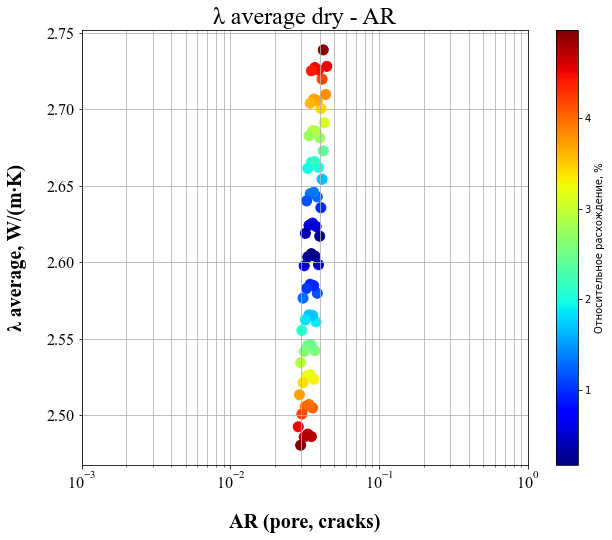

In [ ]:
path_to_ser2 = path2
df_ues2 = pd.read_excel(path_to_ser2, sheet_name='Step 2')
df_ues2.head()

# Delte duplicate values in rows
# drop2= df_ues2.drop_duplicates(subset=["АО пор 1"])
# x2_values, y2_values = drop2["АО пор 1"], drop2["L_eff_1"]


# Without delte duplicate values in rows
x_values2, y_values2 = df_ues2["АО пор 1"], df_ues2["L_eff_1"]

csfont = {'fontname':'Times New Roman'}
fig,ax = plt.subplots(figsize=(10, 8))
plt.grid(True)


plt.scatter(x=x_values2,
            y=y_values2,
            c = abs(df_ues2["Diff_1"]),
            vmin=abs(df_ues2["Diff_1"]).min(),
            vmax=abs(df_ues2["Diff_1"]).max(),
            cmap='jet',
            s=100)

plt.xlim(10**-3., 10**0.)
# For the y axis, we need to flip by passing in the scale values in reverse order
# plt.ylim(2.30, 2.40)
# Add in labels for the axes
plt.ylabel('λ average, W/(m∙K)', fontsize=20, **csfont, fontweight='bold', labelpad=20)
plt.xlabel('AR (pore, cracks)', fontsize=20, **csfont, fontweight='bold', labelpad=20)
plt.xticks(fontsize=16, **csfont)
plt.yticks(fontsize=16, **csfont)
# Make the colorbar show
plt.colorbar(label='Относительное расхождение, %')
plt.title('λ average dry - AR', **csfont, fontsize=24)
plt.xscale("log")
plt.grid(True, which="both", ls="-")
plt.show()

### Comparing cross-polt "λ average dry - AR" for 3 saturation states and one saturation state - dry!

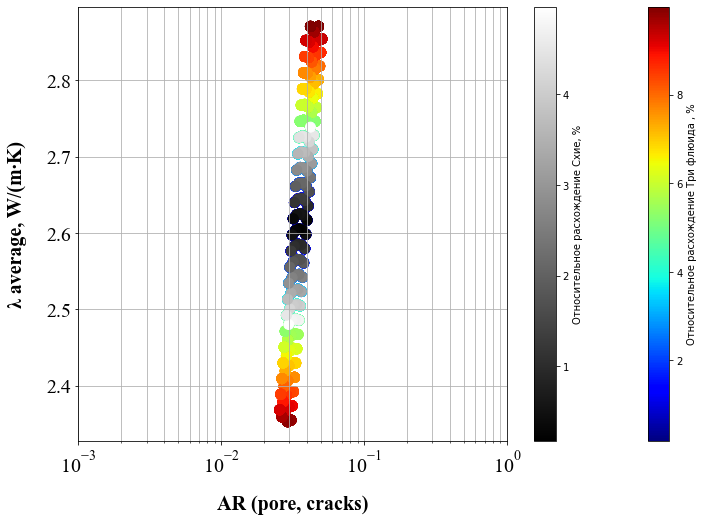

In [ ]:
csfont = {'fontname':'Times New Roman'}
fig,ax = plt.subplots(figsize=(12, 8))
plt.grid(True)

path1 = Path(r'/Users/maryiakalinina/Desktop/Индия_моделирование/Обратная_три флюида/INDIA_L-15_Fsp-Qz(a)_INV_3.xlsx')
path_to_ser = path1
df_ues1 = pd.read_excel(path_to_ser, sheet_name='Step 3')


x_values, y_values = df_ues1["АО пор 1"], df_ues1["L_eff_1"]
x_values2, y_values2 = df_ues2["АО пор 1"], df_ues2["L_eff_1"]

plt.scatter(x=x_values,
            y=y_values,
            c = abs(df_ues1["Diff_1"]),
            vmin=abs(df_ues1["Diff_1"]).min(),
            vmax=abs(df_ues1["Diff_1"]).max(),
            cmap='jet',
            s=100)
plt.colorbar(label='Относительное расхождение Три флюида , %')

plt.scatter(x=x_values2,
            y=y_values2,
            c = abs(df_ues2["Diff_1"]),
            vmin=abs(df_ues2["Diff_1"]).min(),
            vmax=abs(df_ues2["Diff_1"]).max(),
            cmap='gray',
            s=100)
plt.colorbar(label='Относительное расхождение Схие, %')

plt.xlim(10**-3., 10**0.)

# Add in labels for the axes
plt.ylabel('λ average, W/(m∙K)', fontsize=20, **csfont, fontweight='bold', labelpad=20)
plt.xlabel('AR (pore, cracks)', fontsize=20, **csfont, fontweight='bold', labelpad=20)

plt.xticks(fontsize=20, **csfont)
plt.yticks(fontsize=20, **csfont)
# plt.legend()
# Make the colorbar show
# plt.title('TC - AR. Dry - 0.8, Water - 0.2', **csfont, fontsize=24)
plt.xscale("log")
plt.grid(True, which="both", ls="-")


plt.show()

### Comparing histograms with pore aspect ratio for (1) 3 saturation states and (2) one saturation state - dry!

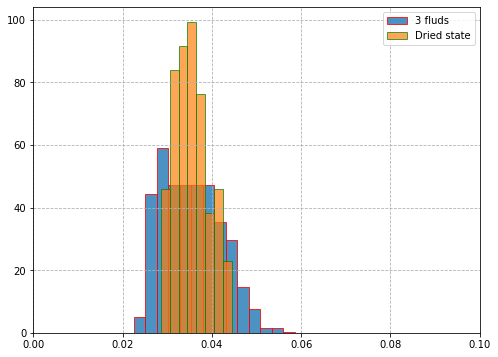

In [ ]:
fig,ax = plt.subplots(figsize=(8, 6))

# generating two series of random values
# using numpy random module of shape (500,1)
series1 = df_ues1["АО пор 1"]
series2 = df_ues2["АО пор 1"]

# plotting histogram

plt.hist(series1, bins='sturges', density=1, label='3 fluds', alpha=.8, edgecolor='red')
plt.hist(series2, bins='sturges', density=1, label='Dried state', alpha=0.7, edgecolor='green')
plt.legend()



# plt.xscale('log', base=10)
plt.grid(True, which="both", ls="--")
plt.xlim(0, 10**-1)

# Showing the plot using plt.show()
plt.show()

In [ ]:
# Delte duplicate values in rows
x = df_ues1.drop_duplicates(subset=["АО пор 1"])
x2 = df_ues2.drop_duplicates(subset=["АО пор 1"])

In [ ]:
x["АО пор 1"].describe()

count    53.000000
mean      0.037767
std       0.010660
min       0.022491
25%       0.028576
50%       0.036308
75%       0.046132
max       0.058614
Name: АО пор 1, dtype: float64

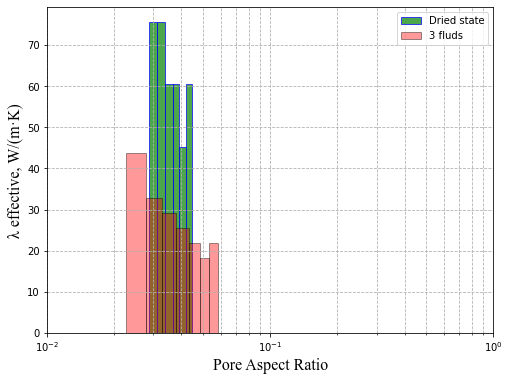

In [ ]:
fig,ax = plt.subplots(figsize=(8, 6)) # Instantiate figure and axes object

series1 = x["АО пор 1"]
series2 = x2["АО пор 1"]

# plotting histogram
ax.hist(series2, bins='auto', density=True, label='Dried state', alpha=.7, color='green', edgecolor='blue')
ax.hist(series1, bins='auto', density=True, label='3 fluds', alpha=.4,color='red', edgecolor='black')
ax.legend(loc='best', fontsize='medium')
ax.set_xlabel('Pore Aspect Ratio', fontsize=16, **csfont)
ax.set_ylabel('λ effective, W/(m·K)', fontsize=16, **csfont)

plt.xscale('log', base=10)
plt.grid(True, which="both", ls="--")
plt.xlim(10**-2, 10**-0)

# Showing the plot using plt.show()
plt.show()

[[0. 7.]
 [0. 7.]] [[0.1 0.1]
 [1.  1. ]]
[[0.09983342 0.65752491]
 [0.84147098 0.70886129]]


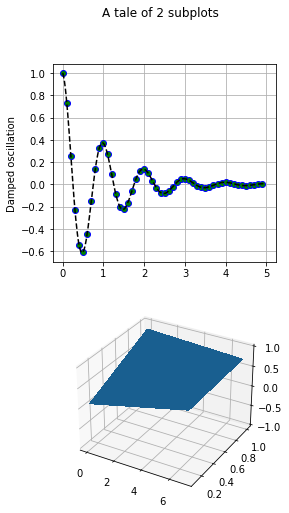

In [ ]:
def f(t):
    return np.cos(2*np.pi*t) * np.exp(-t)


# Set up a figure twice as tall as it is wide
fig = plt.figure(figsize=plt.figaspect(2.))
fig.suptitle('A tale of 2 subplots')

# First subplot
ax = fig.add_subplot(2, 1, 1)

t1 = np.arange(0.0, 5.0, 0.1)
t2 = np.arange(0.0, 5.0, 0.02)
t3 = np.arange(0.0, 2.0, 0.01)

ax.plot(t1, f(t1), 'bo',
        t2, f(t2), 'k--', markerfacecolor='green')
ax.grid(True)
ax.set_ylabel('Damped oscillation')

# Second subplot
ax = fig.add_subplot(2, 1, 2, projection='3d')

x = np.linspace(0.0, 7, 2)
y = np.linspace(0.1, 1, 2)

x1 = np.linspace(x.min(), x.max(), len(x))
y1 = np.linspace(y.min(), y.max(), len(y))


X = x1
Y = y1
X, Y = np.meshgrid(X, Y)
Z = np.sin(np.sqrt(X**2 + Y**2))
print(X, Y)
print(Z)



surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                       linewidth=0, antialiased=False)
ax.set_zlim(-1, 1)

plt.show()

In [ ]:
np.log(0.07)

-2.659260036932778